# Main notebook: computing correlations between offensiveness and popularity
In this notebook we are trying to answer our previous questions: is there a correlation between (positive or negative) between the popularity and the offensiveness of a song ? Let's start by importing our libraries:

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

# This variable should be set to false, unless you are running this notebook without the
# generated datasets
first_time = False

Remember, we have computed the song word count at three levels of "swear word categories":

In [2]:
offensiveness_rating = pd.read_pickle("../pickles/offensiveness_rating_structured")
offensiveness_rating.head()

('TRAAAAV128F421A322', 'non-discriminatory', 'mild', nan)      1
('TRAAAAV128F421A322', nan, nan, nan)                        102
('TRAAABD128F429CF47', nan, nan, nan)                        226
('TRAAAED128E0783FAB', nan, nan, nan)                        421
('TRAAAEF128F4273421', nan, nan, nan)                        139
Name: count, dtype: int64

Now, the problem is that we have tuples as index but we would like to have all these categories in different columns. So we do some processing to take care of that:

In [3]:
def process_tuple(t):
    
    def process_tuple_elem(elem):
        if elem == "nan":
            return np.nan
        else:
            return elem[1:-1]
    return list(map(process_tuple_elem, t[1:-1].replace(" ", "").split(",")))
index_offensiveness = list(map(process_tuple, offensiveness_rating.index.tolist()))

In [4]:
value_offensiveness = list(offensiveness_rating.values)

In [5]:
data_non_flat = list(zip(index_offensiveness, value_offensiveness))

In [6]:
columns = ["track_id", "category", "strength", "target", "value"]
track_off = pd.DataFrame.from_records([elem[0] + [elem[1]] for elem in data_non_flat], columns=columns)
track_off = track_off.set_index(["track_id", "category", "strength", "target"])
track_off.head()

value
track_id           category           strength target       
TRAAAAV128F421A322 non-discriminatory mild     NaN         1
                   NaN                NaN      NaN       102
TRAAABD128F429CF47 NaN                NaN      NaN       226
TRAAAED128E0783FAB NaN                NaN      NaN       421
TRAAAEF128F4273421 NaN                NaN      NaN       139

That's it, we have our multi-index structure. Now, we have the choice: absolute or relative count of swear words in a song ? This choice is rather difficult. But, in some way, even if a song is longer than another one, we can (for now) consider that simply having more swear words is equivalent to being more vulgar. So let's simply count the number of swear words per song:

In [ ]:
%%time 
track_offensiveness = track_off.groupby(by="track_id").apply(lambda frame: frame.reset_index().dropna(thresh = 3).value.sum())
track_offensiveness = track_offensiveness.fillna(0)

And here is our frame relating a song with its offensiveness (so, for example, the song with track ID 'TRAAAAV128F421A322' contains one swear word)

In [15]:
track_offensiveness.head()

,track_id,offensiveness
0,TRAAAAV128F421A322,1.0
1,TRAAABD128F429CF47,0.0
2,TRAAAED128E0783FAB,0.0
3,TRAAAEF128F4273421,0.0
4,TRAAAEW128F42930C0,0.0


Let's save this:

In [14]:
if first_time:
    track_offensiveness.to_csv("../datasets/track_offensiveness.csv")
else:
    track_offensiveness = pd.read_csv("../datasets/track_offensiveness.csv", header=-1)
    track_offensiveness.columns = ["track_id", "offensiveness"]

We take only the columns we are interested in:

In [11]:
song_info = pd.read_csv("../datasets/total.csv")[["track_id", "genre", "song_hotness",
                                                            "song_id", "title", "year"]]

### English songs
We now want to do our analysis for english songs only so we read the corresponding track IDs. The process of "detecting" which songs are in english is described in [this notebook](handling_languages.ipynb).

In [12]:
english_songs = pd.read_csv("../datasets/tracks_english.csv", header=-1)[1]
print("We have {} english songs.".format(english_songs.shape[0]))
english_songs = english_songs.to_frame()
english_songs.columns = ["track_id"]
english_songs.head()

We have 202115 english songs.


,track_id
0,TRAAAAV128F421A322
1,TRAAABD128F429CF47
2,TRAAAED128E0783FAB
3,TRAAAEF128F4273421
4,TRAAAEW128F42930C0


In [28]:
english_track_offensiveness = english_songs.merge(track_offensiveness.reset_index(), on="track_id")
english_track_offensiveness.drop("index", axis=1, inplace=True)
print("We have {} songs.".format(english_track_offensiveness.shape[0]))
english_track_offensiveness.columns = ["track_id", "abs_offensiveness"]
english_track_offensiveness.head()

We have 202115 songs.


,track_id,abs_offensiveness
0,TRAAAAV128F421A322,1.0
1,TRAAABD128F429CF47,0.0
2,TRAAAED128E0783FAB,0.0
3,TRAAAEF128F4273421,0.0
4,TRAAAEW128F42930C0,0.0


In [29]:
song_info_offensiveness = song_info.merge(english_track_offensiveness.reset_index(), on="track_id")
song_info_offensiveness = song_info_offensiveness.rename(columns={0: "abs_offensiveness"})
song_info_offensiveness.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness
0,TRBEEGF128F42AB67E,NaN,0.000000,SOMYKOX12A8C13D59F,Collision Course,0,9341,0.0
1,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1.0
2,TRBEEEA128F92E7EED,NaN,NaN,SOGLPMS12D02193D69,Fake Messiah (Album Version),2009,9339,0.0
3,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0.0
4,TRBEEXV128F93116C9,NaN,0.227736,SOJHHMQ12AB017C6A6,Don't Ya Ever Leave Me (Live),0,9348,0.0


That's good, we have more than 200000 english songs with absolute offensiveness value. The two other values we will be the most focused on are the song hotness and the year. So we need to keep those where the year is not 0 and the song hotness is not nan. For now, let's proceed by keeping only datapoints with positive hotness value.

### Keep positive hotness datapoints:

In [30]:
song_info_offensiveness_hotness = song_info_offensiveness[song_info_offensiveness.song_hotness > 0]

And now, let's compute the correlation for all songs independent of year:

In [31]:
song_info_offensiveness_hotness.song_hotness.corr(song_info_offensiveness_hotness["abs_offensiveness"])

-0.003571398674347435

So we do not really have a correlation which means something here. Let's try by keeping the hotness = 0 values (if we suppose that those songs were "complete flops"):

In [32]:
song_info_offensiveness.song_hotness.corr(song_info_offensiveness.abs_offensiveness)

-0.0049521674122630678

This does not tell us much neither...

So let's include the year and see what we get:

In [33]:
song_info_YOH = song_info_offensiveness_hotness[song_info_offensiveness_hotness.year > 0]
song_info_YOH.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness
5,TRBEEZO12903D05259,NaN,0.520345,SOUDWTU12AC37746F7,Spade and Parade,1994,9350,1.0
9,TRBEENZ12903CE81F8,NaN,0.386477,SOPAKAJ12AB0188E86,Why I Liked Bikini Kill,1995,9344,0.0
10,TRBEELS128F42B63A8,NaN,0.557188,SOPPTXH12A8C1409BC,Sent By Angels,1992,9343,0.0
12,TRBEEIV128F425DAA0,NaN,0.492714,SODLELQ12A8C137D00,To All A Good Night,2000,9342,0.0
13,TRBEMOM128F933A303,NaN,0.637593,SOUCJJT12A58A79086,Life In The Rain,2001,9445,0.0


And the correlation for songs where we have the year is:

In [34]:
song_info_YOH.song_hotness.corr(song_info_YOH.abs_offensiveness)

0.0028210739649093598

Still not significant, but it increased (even if the increase is very small)

In [35]:
# group by:
year_correlation = song_info_YOH.groupby(by="year").apply(lambda frame: frame.song_hotness.corr(frame.abs_offensiveness))

# we drop the years where we have too few songs and we rename the columns
year_correlation = year_correlation.dropna()
year_correlation = year_correlation.to_frame().reset_index()
year_correlation.columns = ["year", "correlation"]

C:\Users\Ahmed Kulovic\AppData\Local\conda\conda\envs\ada\lib\site-packages\numpy\lib\function_base.py:3154: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Ahmed Kulovic\AppData\Local\conda\conda\envs\ada\lib\site-packages\numpy\lib\function_base.py:3088: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


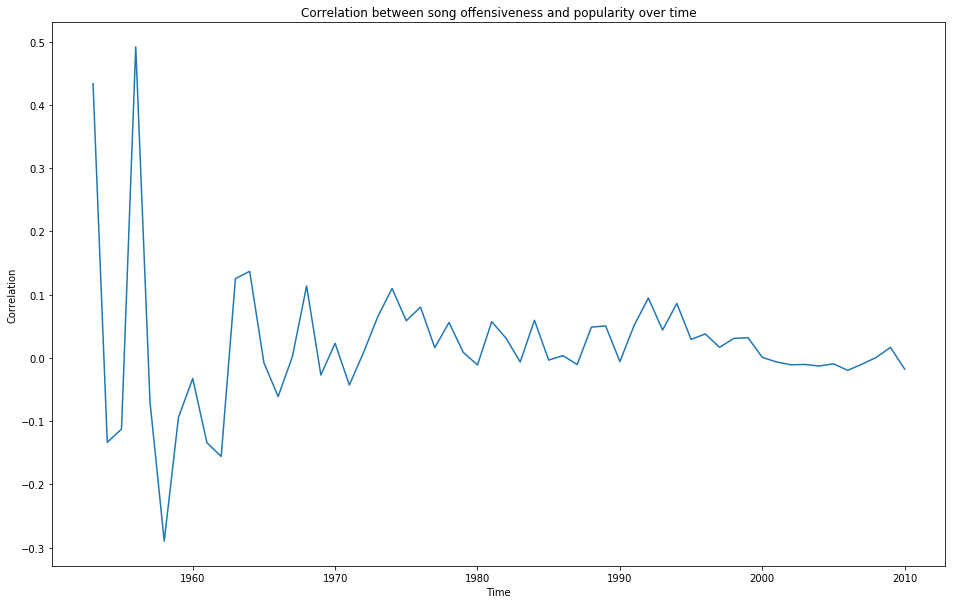

In [62]:
plt.figure(figsize=(16, 10))
plt.title("Correlation between song offensiveness and popularity over time")
plt.ylabel("Correlation")
plt.xlabel("Time")
plt.plot(year_correlation.year.tolist(), year_correlation.correlation.tolist())
plt.show()

### Category, strength and target-based correlations
Until now we computed the general offensiveness of a song. But we would also like to see how the popularity and the offensiveness relate in terms of categories of swear words. So let's proceed by defining a function for getting the offensiveness only based on one combination of category, strength and target: 

In [60]:
def correlate_for_swear_attributes(track_off, category="none", strength="none", target="none", plot_now=True):
    """
    This method plots the date correlations for the specified parameters. If the 3 are "none"
    then the correlations will be computed based on all swear words.
    """
    def get_off_count_based_on(track_off, category, strength, target):
        track_off_nidx = track_off.reset_index().fillna("none")
        return track_off_nidx.query("(category == @category and strength == @strength and target == @target) or\
                                (category == 'none' and strength == 'none' and target == 'none')").replace("none", np.nan)
    def get_off_based_on(track_off, category, strength, target):
        count_off = get_off_count_based_on(track_off, category, strength, target)
        count_off_non_na = count_off[count_off.duplicated("track_id", keep=False)].dropna(thresh=3)
        count_off_non_na.loc[:, "offensiveness"] = count_off_non_na["value"]
        count_off_na = count_off.drop_duplicates("track_id",keep=False)
        count_off_na.insert(0, "offensiveness", 0)
        return pd.concat([count_off_non_na, count_off_na])[["track_id", "offensiveness"]]
    
    all_swear_words = category == "none" and strength == "none" and target == "none"
    
    english_songs = pd.read_csv("../datasets/tracks_english.csv", header=-1)[1].to_frame()
    english_songs.columns = ["track_id"]
    song_info = pd.read_csv("../datasets/total.csv")[["track_id", "genre", "song_hotness",
                                                            "song_id", "title", "year"]]
    label = "all"
    if all_swear_words:
        # We want all categories/strength/targets:
        print("Correlations for all swear words:")
        if first_time:
            track_off_group = track_off.groupby(by="track_id").apply(lambda frame: frame.reset_index().dropna(thresh = 3).value.sum())
            track_off_group = track_off_group.fillna()
        else:
            track_off_group = pd.read_csv("../datasets/track_offensiveness.csv", header=-1)
            track_off_group.columns = ["track_id", "offensiveness"]
    else:
        print("Correlations for category = {}, strength = {} and target = {}".format(category, strength, target))
        label = "{}, {}, {}".format(category, strength, target)
        track_off_group = get_off_based_on(track_off, category, strength, target)
        
    english_track_offensiveness = english_songs.merge(track_off_group.reset_index(), on="track_id")
    song_info_offensiveness = song_info.merge(english_track_offensiveness, on="track_id")
    song_info_offensiveness = song_info_offensiveness[["track_id", "song_hotness", "year", "offensiveness"]]
    song_info_offensiveness = song_info_offensiveness.dropna().query("year > 0 and song_hotness > 0")
    year_correlation = song_info_offensiveness.groupby(by="year").apply(lambda frame: frame.song_hotness.corr(frame.offensiveness))
    year_correlation = year_correlation.dropna()
    year_correlation = year_correlation.to_frame().reset_index()
    year_correlation.columns = ["year", "correlation"]
    
    plt.plot(year_correlation.year.tolist(), year_correlation.correlation.tolist(), label = label)
    if plot_now:
        plt.show()
    # return year_correlation
    # english_track_offensiveness.columns = ["track_id", "abs_offensiveness"]
    
#correlate_for_swear_attributes(track_off, "non-discriminatory", "mild", "none")

Now let's go over all the category-strength-target combinations and plot the correlations for each of them:

Correlations for category = non-discriminatory, strength = mild and target = none


C:\Users\Ahmed Kulovic\AppData\Local\conda\conda\envs\ada\lib\site-packages\numpy\lib\function_base.py:3154: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Ahmed Kulovic\AppData\Local\conda\conda\envs\ada\lib\site-packages\numpy\lib\function_base.py:3088: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


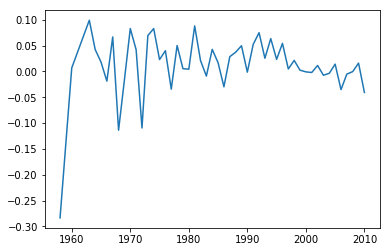

Correlations for all swear words:


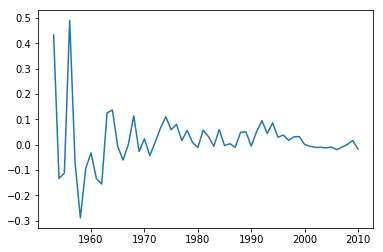

Correlations for category = discriminatory, strength = mild and target = mentalorphysicalability


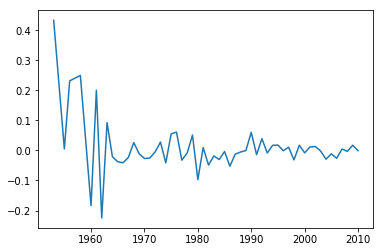

Correlations for category = discriminatory, strength = strongest and target = race


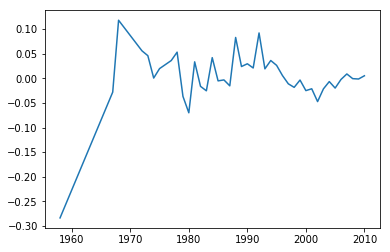

Correlations for category = non-discriminatory, strength = medium and target = none


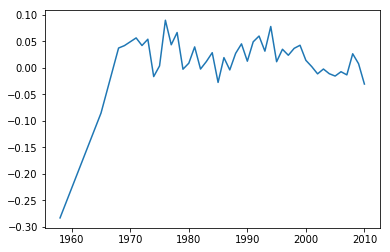

Correlations for category = non-discriminatory, strength = strongest and target = none


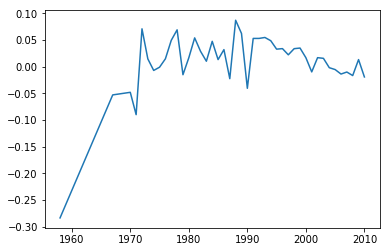

Correlations for category = discriminatory, strength = medium and target = mentalorphysicalability


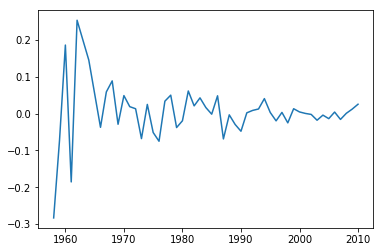

Correlations for category = discriminatory, strength = mild and target = sexuality


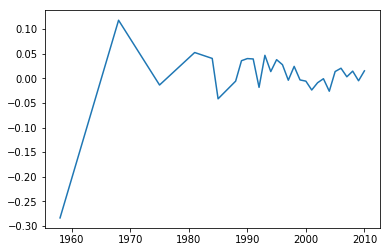

Correlations for category = discriminatory, strength = strongest and target = mentalorphysicalability


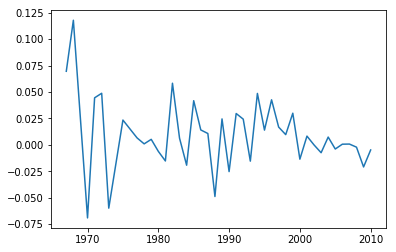

Correlations for category = non-discriminatory, strength = strong and target = none


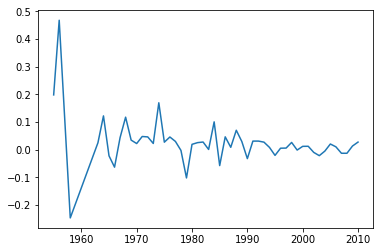

Correlations for category = discriminatory, strength = strong and target = sexuality


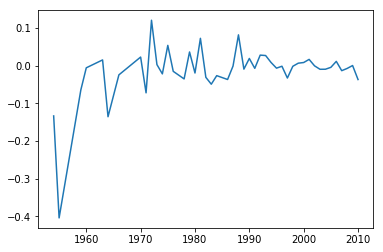

Correlations for category = discriminatory, strength = medium and target = race


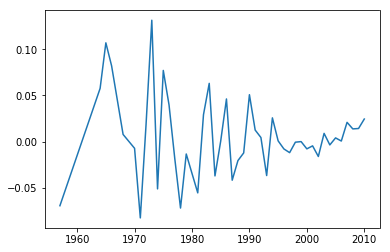

In [38]:
all_combinations = track_off.reset_index()[["category", "strength", "target"]].drop_duplicates()
all_combinations = all_combinations.fillna("none")
for i in range(all_combinations.shape[0]):
    row = all_combinations.iloc[i]
    correlate_for_swear_attributes(track_off, row["category"], row["strength"], row["target"])

We see that they all follow the same trend: there is a kind of correlation in the beginning and then it simply tends to 0. We might be tempted to think that, for music in the mid-10th century, popularity is more correlated with offensiveness because of the Second World War but this is probably wrong. In the following we will see that we have very little data for those years so it is normal that the correlations are much stronger as soon as one song has one word that is interpreted as a swear word by our algorithms (sometimes it makes mistakes because the lyrics data: we will see an example where the lyrics contain the words Whoo - hoo which doesn't mean anything but MusixMatch put the "hoo" as "ho", which is a swear word in our data).
Let us take a few of them and put them in out report

In [45]:
combinations_to_show = all_combinations.sample(8)
combinations_to_show.head()

,category,strength,target
68,discriminatory,mild,sexuality
11,non-discriminatory,medium,none
26,discriminatory,medium,mentalorphysicalability
200,discriminatory,strong,sexuality
1,none,none,none


(8, 3)
Correlations for category = discriminatory, strength = mild and target = sexuality


C:\Users\Ahmed Kulovic\AppData\Local\conda\conda\envs\ada\lib\site-packages\numpy\lib\function_base.py:3154: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Ahmed Kulovic\AppData\Local\conda\conda\envs\ada\lib\site-packages\numpy\lib\function_base.py:3088: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


Correlations for category = non-discriminatory, strength = medium and target = none
Correlations for category = discriminatory, strength = medium and target = mentalorphysicalability
Correlations for category = discriminatory, strength = strong and target = sexuality
Correlations for all swear words:
Correlations for category = non-discriminatory, strength = mild and target = none
Correlations for category = discriminatory, strength = mild and target = mentalorphysicalability
Correlations for category = discriminatory, strength = strongest and target = mentalorphysicalability


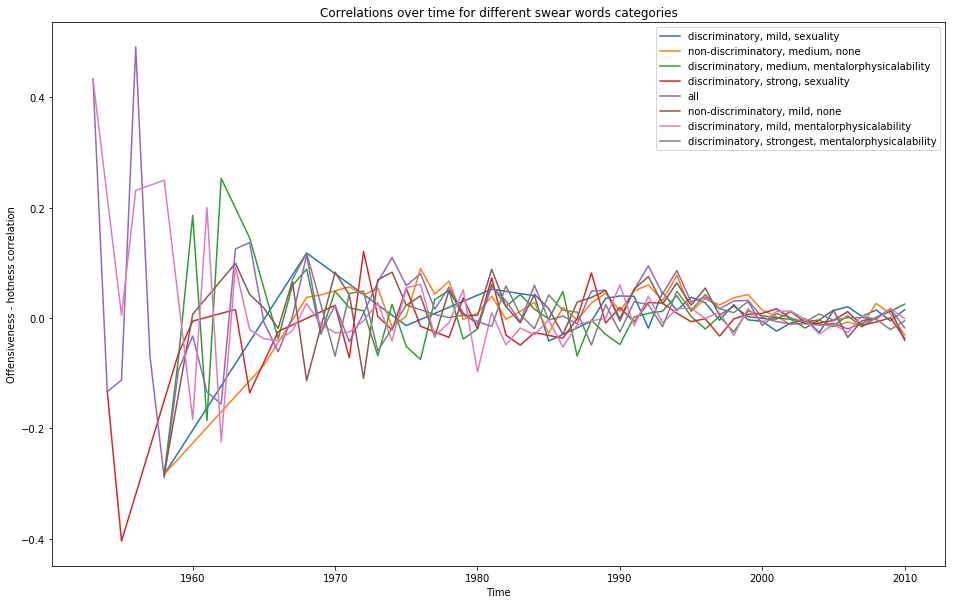

In [61]:
plt.figure(figsize=(16, 10))
print(combinations_to_show.shape)
for i in range(combinations_to_show.shape[0]):
    row = combinations_to_show.iloc[i]
    correlate_for_swear_attributes(track_off, row["category"], row["strength"], row["target"], plot_now=False)
plt.title("Correlations over time for different swear words categories")
plt.xlabel("Time")
plt.ylabel("Offensiveness - hotness correlation")
plt.legend()
plt.show()